**University of San Diego**
AAI-520: Natural Language Processing and GenAI

---

**Professor**: Mirsardar Esmaeili

**Section**: 3

**Group**: 6

**Contributors**:

- Quang Tran
- Alyona Kosobokova
- Ashley Moore

 October, 2025

---

# **Setup & Imports**

- Import core libs (e.g., os, json, time, datetime, pandas, requests).

- Import analysis/plot libs (e.g., matplotlib), and LLM/agents tooling (e.g., LangChain / Gemini client).

- Set global display options and warnings.

In [1]:
!pip install feedparser
!pip install newspaper3k
!pip install gnews
!pip install lxml_html_clean
!pip install streamlit

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 2.2 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=1add11aeb3eb49a06206e4630b47b3265f978bc81144c57d0c8f8dd56c66cf0f
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 65.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.5 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=12916ec4d9e7e666870541c32e7834cace3fc53ab88aad1ed9a3ceb88bad5380
  Stored in directory: /root/.cache/pip/wheels/a5/91/9f/00d664759

In [2]:
import re, os, requests, json, yfinance as yf
from datetime import datetime, timedelta
from getpass import getpass
from langchain.llms.base import LLM
import matplotlib.pyplot as plt
from langchain.agents import initialize_agent, Tool, AgentType
from gnews import GNews
import spacy
import os, requests
from getpass import getpass
from langchain.llms.base import LLM
import math
import streamlit as st
from IPython.display import display, Markdown, HTML
from textwrap import dedent

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# **Configuration & Secrets**

- Load API keys / model names from environment variables (avoid hard-coding).

- Define reusable constants: default ticker, date ranges, cache paths, model  params.

- Toggle debug flags (e.g., DEBUG, SAVE_OUTPUTS).

In [3]:
TRUSTED_SOURCES = [
    "reuters", "bloomberg", "wsj", "cnbc", "financial times", "ft.com",
    "the wall street journal", "the financial times", "the economist", "the new york times",
    "the washington post", "the guardian", "the times", "the telegraph",
    "cnn business", "bbc business", "nbc business", "cbs business", "abc business",
    "the street", "investopedia", "fool.com",
    "marketwatch", "barrons", "economist", "forbes", "morningstar", "yahoo finance",
    "zacks", "seekingalpha", "investopedia", "fool", "thestreet", "nasdaq",
    "bbc", "guardian", "nytimes", "washingtonpost", "time", "npr",
    "abc news", "nbc news", "cbs news", "usa today", "politico", "axios",
    "business insider", "fortune", "fastcompany", "wired", "venturebeat", "protocol",
    "associated press", "apnews", "upi", "businesswire", "prnewswire", "globenewswire",
    "marketwired", "thestockmarketwire", "securities and exchange commission",
    "techcrunch", "arstechnica", "fiercebiotech", "fiercepharma", "medscape",
    "biopharmadive", "supplychaindive", "retaildive", "cfo.com",
    "nikkei", "asiafinancial", "scmp", "south china morning post",
    "the hindu business line", "economic times", "livemint",
    "afr.com", "the australian financial review", "globe and mail", "canadianbusiness",
    "les echos", "handelsblatt", "deutsche welle", "elpais", "expansion",
    "benzinga", "kiplinger", "marketscreener", "tradingeconomics", "fxstreet",
    "cointelegraph", "coindesk", "cryptoslate", "etftrends", "etfdailynews"
]


KEY_TERMS = {"earnings", "sec filing", "guidance", "revenue", "acquisition", "partnership", "ceo", "cfo"}
GEMINI_MODEL = "gemini-2.5-pro"

## **Preprocessing Utilities**

- Clean/normalize news text (lowercasing, de-dup, simple token cleanup).

- Align timestamps across price/news/earnings; handle missing values.

- Optional feature engineering (returns, rolling stats).

In [4]:
def safe_json_parse(raw: str):
    try:
        return json.loads(raw)
    except:
        cleaned = raw.strip()
        cleaned = re.sub(r"^```(json)?", "", cleaned)
        cleaned = re.sub(r"```$", "", cleaned)
        cleaned = cleaned.strip()

        try:
            return json.loads(cleaned)
        except:
            match = re.search(r"\{.*\}", raw, re.DOTALL)
            if match:
                return json.loads(match.group(0))
            raise ValueError(f"Could not parse JSON:\n{raw}")

## **Prompt Templates**

- Centralize all prompts: planning prompt, news summary prompt, earnings extraction prompt, evaluator prompt.

- Keep variables (e.g., {ticker}, {window}, {raw_text}) explicit for reuse.

- Small helper to format prompts safely.

In [5]:
# Display the analysis plan in a readable format
def display_plan(plan_json: str):
    try:
        plan = json.loads(plan_json) if isinstance(plan_json, str) else plan_json
    except Exception as e:
        print("Could not parse plan JSON:", e)
        print(plan_json)
        return

    print("\n Analysis Plan")
    print("="*60)

    steps = plan.get("plan", plan)  # handle both wrapped or plain JSON
    for step in steps:
        num = step.get("step_number", "?")
        action = step.get("action", "")
        tool = step.get("tool_needed", "")
        desc = step.get("description", "")
        print(f" Step {num}: {action}")
        print(f" Tool   : {tool}")
        print(f" Detail : {desc}\n")

    print("="*60)

# Function to display the report in a readable format
def display_report(data: dict, hist_prices=None):
    print("="*60)
    print(f"Financial Report: {data['symbol']}")
    print("="*60)

    # Price Analysis
    print("\n Price Analysis")
    pa = data["price_analysis"]
    print(f"   Current Price      : {pa['current_price']}")
    print(f"   30-Day Moving Avg  : {pa['30d_moving_avg']}")
    print(f"   Trend              : {pa['trend']}")

    # News Analysis
    print("\n News Analysis")
    na = data["news_analysis"]
    print(f"   Sentiment     : {na['sentiment']}")
    print(f"   Classification: {na['classification']}")
    print(f"   Summary       : {na['Summary']}")

    # Earnings Analysis
    print("\n Earnings Analysis")
    ea = data["earnings_analysis"]
    print(f"   EPS       : {ea['EPS']}")
    print(f"   Revenue   : {ea['Revenue']}")
    print(f"   Guidance  : {ea['Guidance']}")
    print(f"   Summary   : {ea['Summary']}")

    print("\n" + "="*60)

      # Chart: Price trend
    if hist_prices is not None and not hist_prices.empty:
        plt.figure(figsize=(10,5))
        plt.plot(hist_prices.index, hist_prices["Close"], label="Close Price", linewidth=2)
        plt.axhline(y=float(pa["30d_moving_avg"]), color="red", linestyle="--", label="30D Moving Avg")
        plt.title(f"{data['symbol']} - Last 30 Days Price Trend")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()

## **Agent Definitions**

- InvestmentResearchAgent (orchestrator): plans tasks, calls router, assembles results.

- NewsAnalyzer: summarizes finance news, extracts sentiment/key points.

- EarningsAnalyzer: extracts EPS/revenue/surprise; summarizes quarter highlights.

- EvaluatorAgent: checks clarity/accuracy/completeness; proposes fixes.

## **Data Fetchers for Market & News**

- get_price_data(ticker, period, interval) → pull price/volume.

- get_earnings_data(ticker) → EPS, revenue, surprise, dates.

- get_news_items(query or ticker) → headlines/snippets/timestamps from a feed/API.

Finance Tools:
Retrives Stock Prices Data from Yahho Finanace

In [7]:
def get_price_data(ticker: str):
  stock = yf.Ticker(ticker)
  hist = stock.history(period="30d")
  if hist.empty:
      return {"current_price": None, "30d_moving_avg": None, "trend": "unknown"}

  current_price = float(hist["Close"].iloc[-1])
  moving_avg = float(hist["Close"].mean())
  trend = "up" if current_price > moving_avg else "down"

  return {
      "current_price": f"{current_price:.2f}",
      "30d_moving_avg": f"{moving_avg:.2f}",
      "trend": trend,
  }

def get_eps_revenue(ticker: str):
  t = yf.Ticker(ticker)

  cal = t.get_earnings_dates(limit=8).sort_index()
  eps = float(cal[cal["Reported EPS"].notna()].iloc[-1]["Reported EPS"])
  revenue = int(t.quarterly_income_stmt.loc["Total Revenue"].iloc[0])

  return {
      "EPS": f"{eps:.2f} USD/share",
      "Revenue": f"${revenue:,.0f} (USD)"
  }

# News Section

News Tools

In [8]:
def fetch_news(ticker: str, max_articles: int = 1):
    google_news = GNews(language="en", country="US", period="90d", max_results=20)
    results = google_news.get_news(f"{ticker} stock")

    cutoff = datetime.now() - timedelta(days=90)
    articles = []

    for article in results:
        title = article.get("title", "")
        summary = article.get("description", "")
        publisher = article.get("publisher", {}).get("title", "")
        pub_date_str = article.get("published date", "")

        pub_date = None
        try:
            pub_date = datetime.strptime(pub_date_str, "%a, %d %b %Y %H:%M:%S %Z")
        except:
            pass

        if publisher.lower() not in TRUSTED_SOURCES:
            continue
        if pub_date < cutoff:
            continue

        articles.append({
            "title": title,
            "summary": summary,
            "publisher": publisher,
            "publishedAt": pub_date.isoformat(),
            "url": article.get("url", "")
        })

        if len(articles) >= max_articles:
            break

    return articles


def _aggregate_news(items: list[dict]) -> str:
    parts = []
    for i, it in enumerate(items, 1):
        title = it.get("title", "")
        summary = it.get("summary", "")
        parts.append(f"[{i}] {title}\n{summary}")
    return "\n\n---\n\n".join(parts).strip()


# New Section

LLM Tools

In [9]:
# Gemini API wrapper
def call_gemini(prompt: str, model: str = "gemini-2.5-pro") -> str:
    url = f"https://generativelanguage.googleapis.com/v1beta/models/{model}:generateContent?key={os.getenv('GOOGLE_API_KEY')}"
    headers = {"Content-Type": "application/json"}
    payload = {"contents": [{"parts": [{"text": prompt}]}]}
    response = requests.post(url, headers=headers, json=payload)
    response.raise_for_status()
    data = response.json()
    text = data["candidates"][0]["content"]["parts"][0]["text"]

    return text

# LangChain LLM wrapper
class GeminiLLM(LLM):
    def _call(self, prompt: str, stop=None) -> str:
        return call_gemini(prompt)
    @property
    def _identifying_params(self): return {"name": "GeminiLLM"}
    @property
    def _llm_type(self): return "custom_gemini"



def analyze_sentiment(text: str) -> str:
    return f"Sentiment: {'positive' if 'strong' in text else 'neutral'}"

tools = [
    Tool(name="FetchNews", func=fetch_news, description="Fetch recent news for a stock ticker"),
    Tool(name="SentimentAnalyzer", func=analyze_sentiment, description="Classify news as positive, neutral, or negative"),
]

llm = GeminiLLM()
sub_agent = initialize_agent(tools, llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION, verbose=True, handle_parsing_errors=True)

/tmp/ipython-input-3673690318.py:33: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  sub_agent = initialize_agent(tools, llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION, verbose=True, handle_parsing_errors=True)


# **Multi Class Agent with Pipeline Orchestrator**

- run_multi_agent_pipeline(ticker, options) glues everything:

- plan → 2) chain → 3) route → 4) analyze → 5) evaluate → 6) memory → 7) assemble output.

- Time each step; collect pass/fail gates; handle exceptions gracefully.

- Returns the final structured JSON:

In [12]:
class InvestmentResearchAgent:
    def __init__(self, ticker: str):
        self.ticker = ticker
        self.memory = []
        self.plan = None

    def plan_steps(self, context: str = ""):
        prompt = f"""
        You are a financial analyst. Given the stock ticker: {self.ticker} and context: {context},
        return a JSON-structured plan, where each step has:
          - step_number
          - action
          - tool_needed
          - description
        """
        raw = call_gemini(prompt)
        return safe_json_parse(raw)

    def prompt_chain(self, news_text: str):
        clean = news_text.strip()
        classification = self.route(clean)
        facts = call_gemini(f"Extract key financial metrics from this text:\n{clean}")
        summary = call_gemini(f"Summarize in 3 sentences and limit in 200 words:\n{facts}")
        return {"classification": classification, "summary": summary}

    def route(self, text: str):
        doc = nlp(text)
        ents = [(ent.text, ent.label_) for ent in doc.ents]

        orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
        persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
        money = [ent.text for ent in doc.ents if ent.label_ in ("MONEY", "PERCENT")]
        dates = [ent.text for ent in doc.ents if ent.label_ == "DATE"]

        if orgs and money:
            category = "earnings"
        elif len(orgs) >= 2:
            category = "merger/acquisition"
        elif persons and orgs:
            category = "executive news"
        else:
            category = "general"

        # call gemini for detailed analysis only one time
        analysis = call_gemini(f"Category: {category}\nNews:\n{text}\n\nProvide a detailed {category} analysis.")

        return {
            "category": category,
            "entities": ents,
            "analysis": analysis
        }

    def evaluate_and_refine(self, analysis_text: str) -> str:
      critique = call_gemini(
          "Critique the following financial analysis for accuracy, clarity, relevance, "
          "and actionability for investors:\n\n" + analysis_text
      )
      improved = call_gemini(
          f"Original analysis:\n{analysis_text}\n\nCritique:\n{critique}\n\n"
          "Rewrite the analysis applying all improvements. Return only the improved analysis."
      )
      return improved

    def remember(self, note: str): self.memory.append(note)
    def recall(self): return "\n".join(self.memory[-3:]) if self.memory else "No past memory."

      # orchestrator
    def run(self, context: str = "", max_articles: int = 5) -> dict:
        self.plan = self.plan_steps(context)
        print("Plan:", self.plan_steps(context))

        # 1) fetch news
        items = fetch_news(self.ticker, max_articles=max_articles)

        price = get_price_data(self.ticker)
        eps_rev = get_eps_revenue(self.ticker)

        # 2) aggregate all articles into one text block
        combined_text = _aggregate_news(items)

        # 3) single-pass analysis on the aggregated text
        chained = self.prompt_chain(combined_text)
        routed  = self.route(combined_text)
        refined = self.evaluate_and_refine(routed["analysis"])

        # 4) one overall sentiment on the combined text
        overall_sentiment = analyze_sentiment(combined_text)

        # 5) the summary from all news
        news_rows = {
            "sentiment": overall_sentiment,
            "classification": routed["category"],
            "Summary": refined,
        }

        # 6) ask LLM ONCE to fill earnings based on aggregate
        base = {
            "symbol": self.ticker,
            "price_analysis": price,
            "news_analysis": news_rows,
            "earnings_analysis": {
                "EPS": eps_rev["EPS"],
                "Revenue": eps_rev["Revenue"],
                "Guidance": "<number here>",
                "Summary": "<text here> - keep limit to 200 words"
            }
        }

        fill_prompt = f"""
    You are a financial analysis assistant.
    Using ONLY the AGGREGATED analysis below, fill the Summary and Guidance fields in earnings_analysis.
    Do not change price_analysis, news_analysis, EPS or Revenue.

    Aggregated classification: {routed['category']}
    Prompt-chain summary: {chained.get('summary','')}
    Aggregated refined analysis:
    {refined}

    JSON:
    {json.dumps(base, indent=2)}
    """
        filled = safe_json_parse(call_gemini(fill_prompt))
        earnings = filled.get("earnings_analysis", base["earnings_analysis"])

        return {
            "symbol": self.ticker,
            "price_analysis": price,
            "news_analysis": news_rows,
            "earnings_analysis": earnings,
        }


# New Section

In [13]:
os.environ["GOOGLE_API_KEY"] = getpass("Enter your Google API key: ")

agent = InvestmentResearchAgent("AAPL")  # MSFT, NVDA, TSLA, MDT
result = agent.run()
print(json.dumps(result, indent=2))

Enter your Google API key: ··········
Plan: {'plan': [{'step_number': 1, 'action': 'Get Company Profile', 'tool_needed': 'company_profile', 'description': "Retrieve essential company information for AAPL, including its business description, industry, sector, and key executives. This provides a foundational understanding of the company's operations and market position."}, {'step_number': 2, 'action': 'Get Real-Time Stock Quote', 'tool_needed': 'get_stock_quote', 'description': "Fetch the latest stock price, daily trading volume, market capitalization, and key valuation metrics like P/E ratio for AAPL. This gives a current snapshot of the stock's market valuation."}, {'step_number': 3, 'action': 'Analyze Annual Financial Statements', 'tool_needed': 'get_financial_statements', 'description': 'Examine the annual income statement, balance sheet, and cash flow statement for the past 3-5 years. This will help in assessing revenue growth, profitability trends, debt levels, and overall financia

# New Section

In [18]:
stock = yf.Ticker("AAPL")
hist = stock.history(period="30d") # Get last 30 days of price data

Financial Report: AAPL

 Price Analysis
   Current Price      : 248.41
   30-Day Moving Avg  : 246.06
   Trend              : up

 News Analysis
   Sentiment     : Sentiment: neutral
   Classification: merger/acquisition
   Summary       : ### Merger & Acquisition Analysis: Apple Inc. (AAPL)

While recent headlines focus exclusively on Apple's strong stock performance and rising valuation, they contain no information regarding new merger or acquisition (M&A) activity. This is consistent with the company's long-standing strategy. However, an investor should interpret Apple's powerful financial position—bolstered by the very market strength noted in the headlines—as a key enabler of its strategic acquisition potential.

#### 1. Context of Current Headlines: Business as Usual

The provided headlines correctly indicate positive momentum in Apple's stock price and analyst sentiment. The absence of major M&A news within this context is not an oversight but rather reflects Apple's established

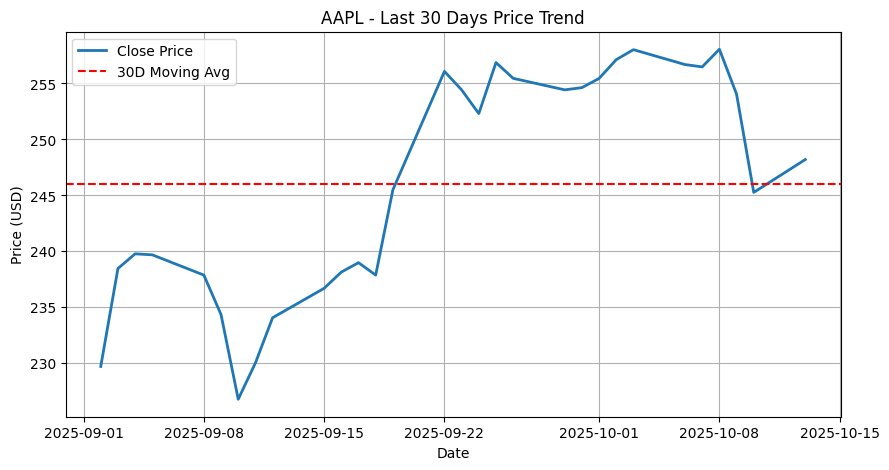

In [20]:
display_report(result, hist)

In [ ]:
agent = InvestmentResearchAgent("NVDA")  # MSFT, NVDA, TSLA, MDT
result = agent.run()
print(json.dumps(result, indent=2))

Enter your Google API key: ··········
Plan: [{'step_number': 1, 'action': 'get_company_overview', 'tool_needed': 'financial_data_tool', 'description': 'Obtain a high-level summary of NVIDIA (NVDA), including its business description, industry, sector, market capitalization, P/E ratio, and dividend yield to establish a foundational understanding.'}, {'step_number': 2, 'action': 'get_historical_stock_data', 'tool_needed': 'financial_data_tool', 'description': 'Retrieve historical stock price and volume data for NVDA over the past 5 years to analyze performance trends, volatility, and identify key support and resistance levels.'}, {'step_number': 3, 'action': 'analyze_financial_statements', 'tool_needed': 'financial_data_tool', 'description': "Examine NVDA's annual and quarterly financial statements (Income Statement, Balance Sheet, Cash Flow Statement) to assess revenue growth, profitability, debt levels, and cash flow generation."}, {'step_number': 4, 'action': 'analyze_valuation_and_pr

In [ ]:
stock = yf.Ticker("NVDA")
hist = stock.history(period="30d") # Get last 30 days of price data
display_report(result, hist)